In [73]:
# =============================================================================
#  ECUACIÓN DE CALOR 1D CON ALGORITMO GENÉTICO (DEAP) - VERSIÓN CORREGIDA
#  Integrantes: 
#   Luis Pablo López Iracheta 
#   Diego Mares Rodríguez
#   Francisco Marín Castillo
#  Fecha: 22 de oct de 2025
#  
#  du/dt - d2u/dx2 = 0
#  u(0,t) = u(1,t) = 0
#  u(x,0) = 1/5 sin(3πx)
#  0 < t < inf , 0 < x < 1
# =============================================================================

# =============================================================================
#  ECUACIÓN DE CALOR 1D CON ALGORITMO GENÉTICO - VERSIÓN MEJORADA
# =============================================================================



import operator, math, random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, gp, tools, algorithms

In [74]:
# Definimos los operadores primitivos
pset = gp.PrimitiveSet("MAIN", 2)  # Dos variables de entrada (u, t)
# Renombramos los argumentos para mayor claridad
pset.renameArguments(ARG0='x')  # Variable espacial (esta si es u o x) 
## Estás renombrando ARG0='u', pero ese argumento representa x, no u
pset.renameArguments(ARG1='t')  # Variable tiempo

# Agregamos operadores aritméticos básicos
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)

In [75]:
def safe_div(a, b):
    try:
        return a / b if abs(b) > 1e-6 else 1.0
    except:
        return 1.0
pset.addPrimitive(safe_div, 2)

# Funciones matemáticas seguras
def safe_sin(x): return math.sin(x)
def safe_cos(x): return math.cos(x)
def safe_exp(x):
    try: return math.exp(x) if x < 10 else math.exp(10)
    except: return 1.0
def safe_log(x):
    try: return math.log(abs(x)+1e-6)
    except: return 0.0
def safe_neg_exp(x):
    try:
        return math.exp(-abs(x)) if x > -20 else math.exp(20)
    except OverflowError:
        return 1.0

In [76]:
pset.addPrimitive(safe_neg_exp, 1)
pset.addPrimitive(safe_sin, 1)
pset.addPrimitive(safe_cos, 1)
pset.addPrimitive(safe_exp, 1)
pset.addPrimitive(safe_log, 1)

# Constantes aleatorias
pset.addEphemeralConstant("rand101", lambda: random.uniform(-2, 2))

# Creamos para minimizar la función
try:
    del creator.FitnessMin
    del creator.Individuo
except:
    pass

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Minimizar la función a cero
creator.create("Individuo", gp.PrimitiveTree, fitness=creator.FitnessMin) # Individuo basado en árboles primitivos

In [77]:
# Configuramos la caja de herramientas
toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset, min_=2, max_=4)  # Generador de expresiones
toolbox.register("individuo", tools.initIterate, creator.Individuo, toolbox.expr_init)  # Inicializador de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individuo)  # Inicializador de población
toolbox.register("compile", gp.compile, pset=pset)  # Compilador de árboles a funciones

# Función objetivo: Evaluar el error en la ecuación del calor
xs = np.linspace(0, 1, 10)  # Puntos en el espacio
ts = np.linspace(0, 0.3, 10)  # Puntos en el tiempo, rango reducido para evitar inestabilidades numéricas

In [ ]:
def evaluate_AG(individuo):
    func = toolbox.compile(expr=individuo)
    h = 1e-3
    error_pde = 0.0
    n = 0

    for x in xs:
        for t in ts:
            try:
                u = func(x, t)
                du_dt = (func(x, t+h) - func(x, t-h)) / (2*h)
                d2u_dx2 = (func(x+h, t) - 2*u + func(x-h, t)) / (h**2)
                residuo = du_dt - d2u_dx2
                error_pde += residuo**2
                n += 1
            except (OverflowError, ValueError):
                return (1e6,)

    if n == 0: return (1e6,)

    mse_pde = error_pde / n

    # --- errores físicos principales ---
    mse_pde = error_pde / n
    u_init_error = np.mean([(func(x,0) - 0.2*math.sin(3*math.pi*x))**2 for x in xs])
    border_penalty = sum(abs(func(0,t)) + abs(func(1,t)) for t in ts)

    # --- amplitud: para que no se vuelva plano ---
    amp = np.mean([abs(func(x,0)) for x in xs])
    amp_penalty = 1e-4/(amp + 1e-6)   # favorece amplitud no-cero

    # --- complejidad, funciones no tan largas ---
    size_penalty = len(individuo) * 1e-3

    # --- estructura / forma ---
    expr_str = str(individuo)
    penalty_logx  = 1.0 if "safe_log(x)" in expr_str else 0.0
    penalty_no_exp = 0.5 if "safe_neg_exp" not in expr_str else 0.0

    # --- signo y decaimiento suave ---
    # media espacial en varios tiempos => debe ser positiva, monótona no-creciente y no desaparecer "demasiado" rápido
    times_chk = [0.0, 0.05, 0.1, 0.2, 0.3]
    A = []
    for tt in times_chk:
        A.append(np.mean([func(x, tt) for x in xs]))
    A = np.array(A)

    sign_penalty = 0.1 if A.mean() < 0 else 0.0
    mono_penalty = 0.0
    for i in range(len(A)-1):
        if A[i+1] > A[i] + 1e-6:   # no debe aumentar con t
            mono_penalty += 0.05

    # evita que se “aplane” de golpe: exige que no caiga más rápido que exp(-c_min t)
    c_min = 1.5                        # decaimiento mínimo (suave). Ajustable.
    too_fast = (abs(A[-1]) < abs(A[0]) * math.exp(-c_min * times_chk[-1]))
    speed_penalty = 0.1 if too_fast else 0.0
    
    # Penalizar funciones que no cambian con el tiempo
    t0, t1 = 0.0, 0.2
    u_t0 = np.array([func(x, t0) for x in xs])
    u_t1 = np.array([func(x, t1) for x in xs])
    temporal_diff = np.mean(np.abs(u_t1 - u_t0))
    time_penalty = 0.5 if temporal_diff < 1e-3 else 0

    # Penalizar si u(x,t) no decae con el tiempo
    decay_penalty = 0
    for x in xs:
        u_vals = [func(x, t) for t in ts]
        if any(u_vals[i+1] > u_vals[i] + 1e-3 for i in range(len(u_vals)-1)):
            decay_penalty += 0.2


    # --- mezcla de pesos (ajústalos si quieres) ---
    fitness = (
        1.5 * mse_pde +
        5.0 * u_init_error +
        5.0 * border_penalty +
        0.9 * amp_penalty +
        5.0 * size_penalty +
        1.0 * penalty_logx +
        0.5 * penalty_no_exp +
        1.0 * sign_penalty +
        1.0 * mono_penalty +
        0.9 * speed_penalty +
        1.7 * time_penalty +
        0.8 * decay_penalty
    )


    return (fitness,)

In [79]:
toolbox.register("evaluate", evaluate_AG) # Evaluador de individuos en la población
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=14))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=14))

poblacion = toolbox.population(n=300)
hof = tools.HallOfFame(5)  # guardamos los 5 mejores individuos


In [94]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
#stats.register("avg", np.mean)
#stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

generaciones = 300
p_cruza = 0.4
p_muta = 0.6

In [81]:
for gen in range(generaciones):
    # Evaluamos la población
    invalid_ind = [ind for ind in poblacion if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses): # Asignar fitness
        ind.fitness.values = fit

    # Guardar los mejores (elitismo)
    hof.update(poblacion)
    elites = tools.selBest(poblacion, k=15)  
    offspring = tools.selTournament(poblacion, len(poblacion) - len(elites), tournsize=3)

    # Reproducción (cruce + mutación)
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=p_cruza, mutpb=p_muta)

    # Evaluamos la descendencia
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Nueva población = élites + descendencia
    poblacion[:] = elites + offspring

    record = stats.compile(poblacion)
    if gen % 100 == 0:
        print(f"Gen {gen}: {record}")


Gen 0: {'min': 0.8464517732975038, 'max': 3.5307789918463624e+28}
Gen 100: {'min': 0.27872900745656976, 'max': 8.826947506388251e+21}
Gen 200: {'min': 0.2755593375480719, 'max': 8.826947506388251e+21}


In [82]:
####### Resultados finales
best = hof[0]
f_best = toolbox.compile(expr=best) ########Agregamos fbest, Compila el árbol en una función Python ejecutable   

print("Mejores individuos:")
fun_best = toolbox.compile(expr=best)
print(best)
print("Fitness:", best.fitness.values[0])
print(f"u(0, 0.1) = {fun_best(0, 0.1):.4f}")
print(f"u(0.5, 0.1) = {fun_best(0.5, 0.1):.4f}")
print(f"u(1, 0.1) = {fun_best(1, 0.1):.4f}")
print("Longitud del mejor individuo:", len(best))

Mejores individuos:
safe_neg_exp(safe_exp(safe_exp(safe_cos(safe_div(-0.0018361575483893944, t)))))
Fitness: 0.2755593375480719
u(0, 0.1) = 0.0000
u(0.5, 0.1) = 0.0000
u(1, 0.1) = 0.0000
Longitud del mejor individuo: 7


In [83]:
print("u(0.5, t) =", fun_best(0.5, 0.0))

u(0.5, t) = 0.0038289686261127787


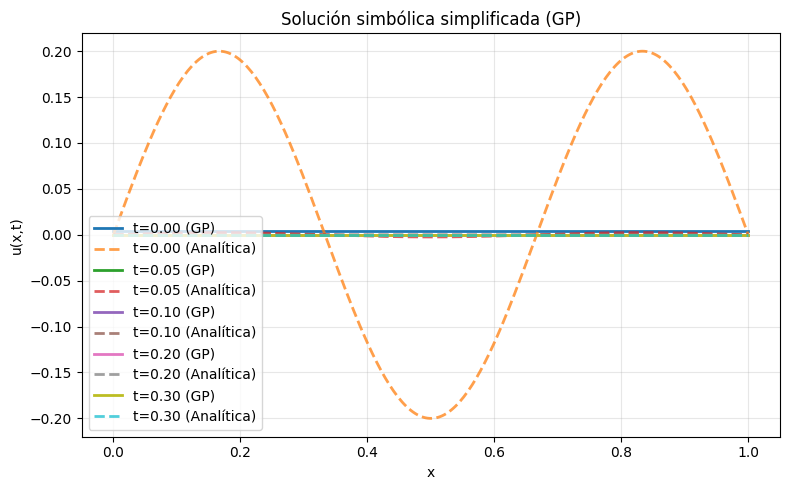


Mejor individuo (árbol GP):
safe_neg_exp(safe_exp(safe_exp(safe_cos(safe_div(-0.0018361575483893944, t)))))


In [98]:
# =========================
# BLOQUE DE GRÁFICAS TIPO "PARTE 7"
# (pegar después de terminar la evolución)
# =========================

import numpy as np
import matplotlib.pyplot as plt

# 1) Asegurar que tenemos el mejor individuo y su función compilada
try:
    best
except NameError:
    # Si no existe, tomarlo del Hall of Fame (asumiendo que lo usaste)
    best = hof[0]

# Compilar si hace falta
try:
    f_best
except NameError:
    f_best = toolbox.compile(expr=best)

# Resolver nombre de la función, por si en tu código se llama distinto
try:
    f = f_best
except NameError:
    try:
        f = fun_best
    except NameError:
        f = fun_best  # última opción si lo llamaste así

# 2) Función segura para evaluar u(x,t)
def safe_u(x, t):
    try:
        v = f(x, t)
        if not np.isfinite(v):
            return np.nan
        return float(np.clip(v, -1e3, 1e3))  # recorte suave para gráficas
    except Exception:
        return np.nan

# 3) (Opcional) Solución analítica para comparar
def u_analitica(x, t):
    return 0.2 * np.sin(3*np.pi*x) * np.exp(-(3*np.pi)**2 * t)

COMPARAR_ANALITICA = True  # pon False si quieres solo la curva GP

# 4) Parámetros de la gráfica
xs = np.linspace(0, 1, 300)
t_list = [0.00, 0.05, 0.10, 0.20, 0.30]

plt.figure(figsize=(8,5))
for tt in t_list:
    u_gp = [safe_u(x, tt) for x in xs]
    plt.plot(xs, u_gp, '-', lw=2, label=(f"t={tt:0.2f} (GP)" if COMPARAR_ANALITICA else f"t={tt:0.2f}"))
    if COMPARAR_ANALITICA:
        u_an = [u_analitica(x, tt) for x in xs]
        plt.plot(xs, u_an, '--', lw=2, alpha=0.75, label=f"t={tt:0.2f} (Analítica)")

plt.title("Solución simbólica simplificada (GP)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=1, frameon=True)
plt.tight_layout()
plt.show()

# (Opcional) imprimir expresión del mejor individuo
print("\nMejor individuo (árbol GP):")
print(best)


In [91]:
print("t=0 in ts? ->", 0.0 in ts, "  min(ts)=", ts.min())

t=0 in ts? -> True   min(ts)= 0.0


In [92]:
xs_dbg = np.linspace(0,1,50)
mse_ci_dbg = np.mean([(f_best(x,0) - 0.2*np.sin(3*np.pi*x))**2 for x in xs_dbg])
print("MSE condición inicial (debug):", mse_ci_dbg)

MSE condición inicial (debug): 0.019297130878476405
